In [115]:
import tensorflow as tf
import tensorflow_datasets as tfds
import IPython.display as display
#from PIL import Image                 # NOTE: PIL is not maintained but Pillow is, and this line works with it...
import matplotlib.pyplot as plt
import numpy as np

In [139]:
# use this to look at which datasets are included
#tfds.list_builders()
ds = tfds.load('mnist', split='train', shuffle_files=True, data_dir='c:\\tensorflow-datasets')
assert isinstance(ds, tf.data.Dataset)
print(ds)

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [140]:
print(ds)

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [141]:
myit = iter(ds)

True Label: 9


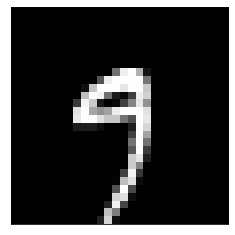

In [166]:
thisInstance = next(myit)
fig = plt.imshow(thisInstance["image"].numpy().squeeze(),cmap='gray', vmin=0, vmax=255)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#img = Image.fromarray(next(myit)["image"])
#img.show
print('True Label: ' + np.array2string(thisInstance["label"].numpy()) )

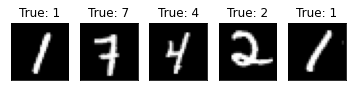

In [183]:
fig,sp_axes = plt.subplots(1,5)
subplotIdx = 0
for inst in ds.take(5):
    sp_axes[subplotIdx].imshow(inst["image"].numpy().squeeze(),cmap='gray',vmin=0,vmax=255)
    sp_axes[subplotIdx].get_xaxis().set_visible(False)
    sp_axes[subplotIdx].get_yaxis().set_visible(False)
    sp_axes[subplotIdx].set_title( 'True: ' + np.array2string(inst["label"].numpy()) )
    subplotIdx += 1